<a href="https://colab.research.google.com/github/Sopralapanca/medium-articles/blob/main/%5BMedium%5DRestrictedBoltzmanMachine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-learn==1.3.2 numpy==1.26.4 pandas==2.1.4 pillow==9.4.0

In this tutorial we will implement from scratch a Restricted Boltzman Machine and train it on the MNIST dataset of handwritten digits. The goal is to encode the image in a latent space and reconstruct the original test images from their hidden encoding and confront the reconstructions with the original image.

# Downloading the dataset

The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. The images are 28x28 pixels.

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)


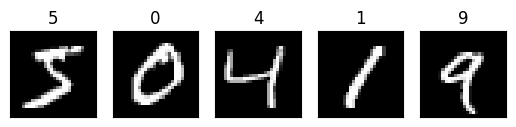

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

X, Y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
print(X.shape)
plot_example(X, Y)

Prepare dataset

In [2]:
# normalize data
X /= 255

# binarize data
X = np.where(X > 0.5, 1, 0)

# train - test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=10000, random_state=42, stratify=Y)

# Implementation of RBM

In [3]:
from sklearn.utils import gen_batches

class RBM():

  def __init__(self, visible_dim, hidden_dim):
    self.visible_dim = visible_dim
    self.hidden_dim = hidden_dim
    # weights
    self.W = np.random.randn(visible_dim, hidden_dim)
    # biases
    self.bh = np.random.randn(hidden_dim)
    self.bv = np.random.randn(visible_dim)


  def fit(self, X, epochs=10, batch_dim=16, lr=0.01):
    '''
    Trains the restricted boltzmann machine
    '''
    for epoch in range(epochs):
      # saving the image of the weights
      self.plot_weights(step=epoch, save=True)

      error_epoch = 0
      batches = list(gen_batches(X.shape[0], batch_dim))

      for batch in batches:
        batch = X[batch.start:batch.stop]
        batch_size = batch.shape[0]

        # Wake - prob of h given v
        ones_poshidP = np.ones((batch_size, self.hidden_dim))
        poshidP = ones_poshidP/(ones_poshidP + np.exp(-np.dot(batch,self.W) - self.bh))
        wake = np.dot(batch.T, poshidP)

        # Dream - prob of v giben h
        ones_reconDataP = np.ones((batch_size, self.visible_dim))
        reconDataP = ones_reconDataP / (ones_reconDataP + np.exp(-np.dot(poshidP, np.transpose(self.W))-self.bv))
        ones_neghidP = np.ones((batch_size, self.hidden_dim))
        neghidP = ones_neghidP / (ones_neghidP + np.exp(-np.dot(reconDataP, self.W) - self.bh))
        dream = np.dot(np.transpose(reconDataP), neghidP)

        # Error
        error = np.sum((batch-reconDataP)**2)/batch_size

        # Update Contrastive Divergence-1
        self.W += lr*(wake-dream)/batch_size
        self.bh += lr*(np.sum(poshidP-neghidP, axis=0))/batch_size
        self.bv += lr*(np.sum(batch-reconDataP, axis=0))/batch_size

        error_epoch += error

      error_epoch /= len(batches)
      print(f"epoch: {epoch}/{epochs} \t{'error:'} {error_epoch}")


  def reconstruct(self, X):
    '''
    Reconstruct the data from the hidden encoding
    '''
    ones_poshidP = np.ones((X.shape[0], self.hidden_dim))
    poshidP = ones_poshidP/(ones_poshidP + np.exp(-np.dot(X,self.W)-self.bh))
    poshidS = poshidP > np.random.uniform(size=poshidP.shape)

    ones_reconDataP = np.ones((X.shape[0], self.visible_dim))
    reconDataP = ones_reconDataP / (ones_reconDataP + np.exp(-np.dot(poshidS,np.transpose(self.W))-self.bv))

    return reconDataP

  def plot_weights(self, title='weights', step=0, save=True):
    '''
    Plot the weights of the RBM, one plot for each hidden unit.
    '''

    cols = 5
    rows = int(self.hidden_dim / cols)


    plt.clf()
    fig, axes = plt.subplots(rows, cols, figsize=(10,10))
    fig.suptitle(f"{title} step:{step}")
    for i in range(rows):
        for j in range(cols):
            axes[i, j].imshow(self.W[:,i*cols+j].reshape(28, 28), cmap='gray')
            axes[i, j].axis('off')

    plt.subplots_adjust(wspace=1, hspace=1)

    if save:
      plt.savefig(f"{title}_step_{step}.png")
    else:
      plt.show()

    plt.close()

# Training

In [4]:
# turn off the interactive mode of matplotlib in order to avoid to show multiple plots
plt.ioff()
rbm = RBM(visible_dim=X_train.shape[1], hidden_dim=30)
rbm.fit(X_train, epochs=20, batch_dim=128, lr=0.7)
plt.ion()

epoch: 0/20 	error: 52.92289854425826
epoch: 1/20 	error: 43.673762194006805
epoch: 2/20 	error: 41.67936743905737
epoch: 3/20 	error: 40.91450508295603
epoch: 4/20 	error: 40.438238491731724
epoch: 5/20 	error: 40.14740743801709
epoch: 6/20 	error: 39.97586459783109
epoch: 7/20 	error: 39.946719534711825
epoch: 8/20 	error: 39.90292420478229
epoch: 9/20 	error: 39.736573164934455
epoch: 10/20 	error: 39.57065841218716
epoch: 11/20 	error: 39.36274984932718
epoch: 12/20 	error: 39.03537864796437
epoch: 13/20 	error: 38.68310353098001
epoch: 14/20 	error: 38.46711190700915
epoch: 15/20 	error: 38.28567853541681
epoch: 16/20 	error: 38.061171013523676
epoch: 17/20 	error: 37.78265500549882
epoch: 18/20 	error: 37.50654823238961
epoch: 19/20 	error: 37.22017407354129


In [5]:
# show the weights over epochs
import glob
from PIL import Image
import re
import math
from pathlib import Path

file_pattern = re.compile(r'.*?(\d+).*?')
def get_order(file):
    match = file_pattern.match(Path(file).name)
    if not match:
        return math.inf
    return int(match.groups()[0])


frames = [Image.open(image) for image in sorted(glob.glob(f"./weights_step_*.png"), key=get_order)]
frame_one = frames[0]
frame_one.save("weights.gif", format="GIF", append_images=frames,
               save_all=True, duration=1000, loop=0)

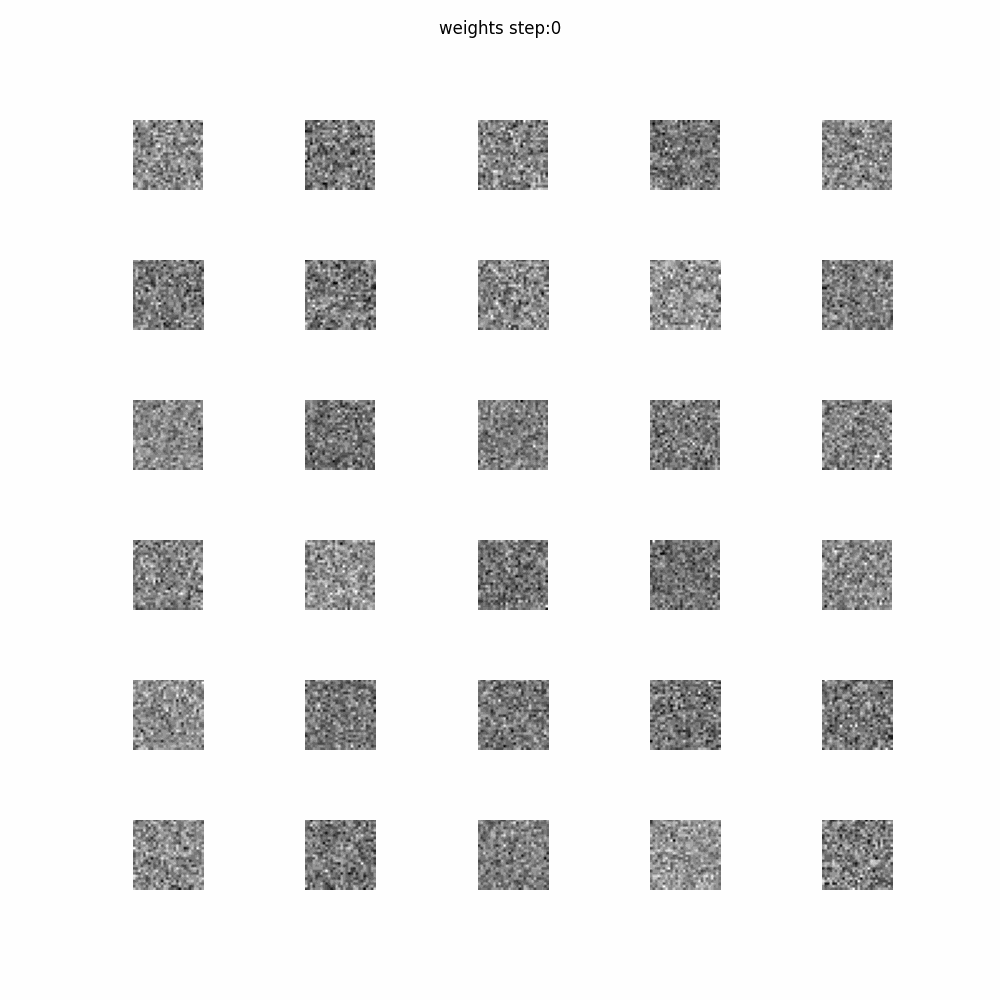

In [6]:
from IPython.display import Image
Image(open('weights.gif','rb').read())

# Testing

In [7]:
# get one image of the test set for each digit
# Create a list of indices for each digit
digit_indices = [np.where(Y_test == str(i))[0][0] for i in range(10)]
resticted_set = X_test[digit_indices]

reconstructed = rbm.reconstruct(resticted_set)



Text(0, 0.5, 'REC.')

<Figure size 640x480 with 0 Axes>

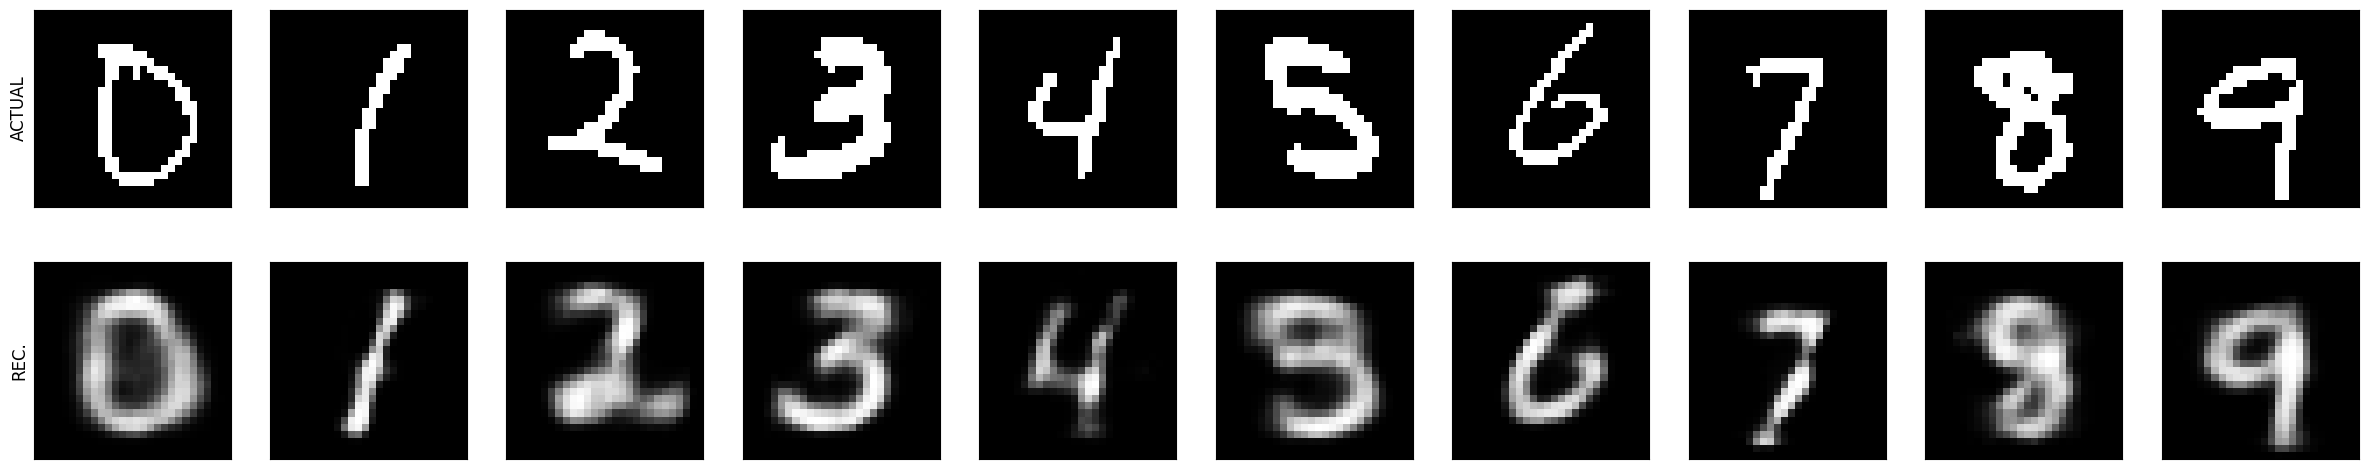

In [8]:
# show 10 sample images
rows = 2
columns = 10

fig, axes = plt.subplots(rows, columns,sharey = True,figsize=(30, 6))
for i in range(rows):
    for j in range(columns):
        if i==0:
          axes[i, j].imshow(resticted_set[j].reshape(28, 28), cmap='gray')
        else:
          axes[i, j].imshow(reconstructed[j].reshape(28, 28), cmap='gray')

        axes[i, j].tick_params(left = False, right = False , labelleft = False,
                labelbottom = False, bottom = False)

axes[0, 0].set_ylabel("ACTUAL", fontsize=12)
axes[1, 0].set_ylabel("REC.", fontsize=12)

# Evaluation Metrics

To measure the similarity between the original image and the reconstructed one the metric used is the SSIM. SSIM index provides a quantitative measure of how similar two images are, taking into account both their content and structure.

In [10]:
from skimage.metrics import structural_similarity as ssim
# reconstruct the whole testset
reconstructed = rbm.reconstruct(X_test)

# convert test set into float numbers to apply ssim score
X_test1 = X_test.astype(float)

ssim_score=0
for i in range(len(X_test1)):
  ssim_score +=ssim(X_test1[i], reconstructed[i], data_range=X_test1[i].max() - X_test1[i].min())

# mean overall the samples
ssim_score /= len(X_test)

print(f"SSIM score: {ssim_score}")

SSIM score: 0.6794428177269172
